In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import math
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms


# Data Loading

In [114]:
# fetch MNIST dataset
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

# fetch only 0 and 7
X = X[np.logical_or(y == '0', y == '7')]
y = y[np.logical_or(y == '0', y == '7')]

X.shape, y.shape

((14196, 784), (14196,))

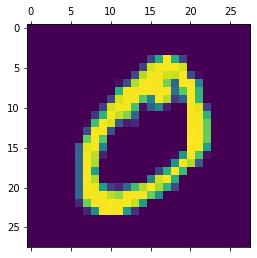

In [115]:
plt.matshow(X.iloc[0,:].to_numpy().reshape(28,28))

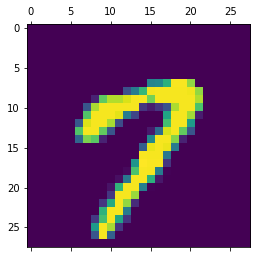

In [116]:
plt.matshow(X.iloc[1,:].to_numpy().reshape(28,28))

In [117]:
X = X.reset_index()
X.drop(["index"],axis=1,inplace=True)
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
y = y.reset_index()
y.drop(["index"],axis=1,inplace=True)
y

,class
0,0
1,7
2,0
3,7
4,0
...,...
14191,7
14192,7
14193,0
14194,7


# 1. Create dataset with bags

In [119]:
# scale pixel values from 0~255 to 0~1
X = X/255
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# concat X and y and shuffle the data
data = pd.concat([X, y],axis=1)
data = data.sample(data.shape[0], random_state=42)
data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
1606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
9538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
11178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
10381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
13418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [121]:
# get samples with label '0' and '7'
data_0 = data[data["class"]=='0']
data_7 = data[data["class"]=='7']

print(data_0.shape, data_7.shape)

(6903, 785) (7293, 785)


In [125]:
# set proportion of '0' in a bag to be 70%
X_li = []
y_li = []

for i in tqdm(range(math.floor(data_0.shape[0]/70))):
    tmp1 = data_0.sample(n=70)
    tmp2 = data_7.sample(n=30)
    tmp = pd.concat([tmp1,tmp2],axis=0)
    
    X_li.append(tmp.iloc[:,:-1].to_numpy().reshape(100,28,28))
    y_li.append(0.7)

X_bag = np.stack(X_li, axis=0)
y_bag = np.array(y_li)

print(X_bag.shape, y_bag.shape)

100%|██████████| 98/98 [00:00<00:00, 338.62it/s]


(98, 100, 28, 28) (98,)


In [123]:
# # Assign 100 images into a bag. There are in total 14196 images, thus there are 141 bags.
# # Input: bag with shape [28, 28, 100]
# # Label: ratio of '7' within the bag

# X_li = []
# y_li = []

# for i in tqdm(range(math.floor(data.shape[0]/100))):
#     temp = data.iloc[i*100:i*100+100, :]
    
# #     X_temp = temp.iloc[:, :-1]
# #     row = []
# #     for i in range(10):
# #         col = []
# #         for j in range(10):
# #             col.append(X_temp.iloc[i*10+j, :].to_numpy().reshape(28,28))
# #         row.append(np.hstack(col))
    
# #     X_temp = X_temp.to_numpy().reshape(100,28,28)
# #     X_temp = np.vstack(row)

#     X_temp = X_temp.reshape(100,28,28)
    
#     y_temp = len(temp[temp.iloc[:, -1]=='7'])/100
    
#     X_li.append(X_temp)
#     y_li.append(y_temp)

# X_bag = np.stack(X_li, axis=0)
# y_bag = np.array(y_li)

# print("X_bag shape: ", X_bag.shape)
# print("y_bag shape: ", y_bag.shape)

100%|██████████| 141/141 [00:01<00:00, 78.27it/s]


X_bag shape:  (141, 280, 280)
y_bag shape:  (141,)


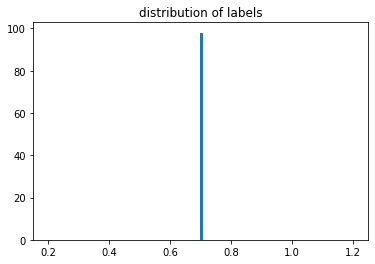

In [126]:
# plot the distribution of labels
plt.title("distribution of labels")
plt.hist(y_bag, bins=150)
plt.show()

# 2. Train-Val-Test

In [136]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_bag, y_bag, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

print("X_train: ", X_train.shape, "y_train: ", y_train.shape)
print("X_val: ", X_val.shape, "y_val: ", y_val.shape)
print("X_test: ", X_test.shape, "y_test: ", y_test.shape)

X_train:  (70, 100, 28, 28) y_train:  (70,)
X_val:  (13, 100, 28, 28) y_val:  (13,)
X_test:  (15, 100, 28, 28) y_test:  (15,)


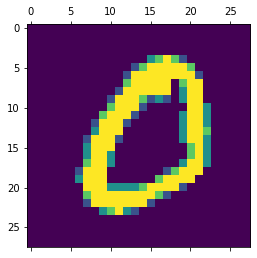

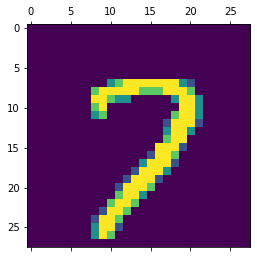

In [140]:
plt.matshow(X_train[0][69])
plt.matshow(X_train[0][70])

# 3. Model Architecture

In [129]:
# ResNet

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        # self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        # self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        # self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                # norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=False, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

# Distribution Pooling Filter

class DistributionPoolingFilter(nn.Module):
    r"""Applies 'distribution' pooling as described in the paper
    `Weakly Supervised Clustering by Exploiting Unique Class Count`_ .
    We have a mini-batch of data Input: :math:`(B, N, J)`, where :math:`B` is number of bags, 
    :math:`N` is number of instances 
    in a bag, :math:`J` is number of extracted features from each instance in a bag.
    Given a bag :math:`X` with :math:`N` instances in the mini-batch, 
    for each instance :math:`x_i \in X`, we have :math:`J` extracted features 
    :math:`[f_{x_i}^j | f_{x_i}^j \in \mathbb{R}, j=1,2, \cdots, J] =\mathbf{f}_{x_i} \in \mathbb{R}^J`.
    Let :math:`\tilde{p}^j_{X}(v)` be the estimated marginal distribution of :math:`j^{th}` feature.
    Estimated marginal distribution :math:`\tilde{p}^j_{X}(v)` is obtained by using kernel 
    density estimation, which employs a Gaussian kernel with standard deviation :math:`\sigma`:
    .. math::
        \tilde{p}^j_{X}(v) = \frac{1}{N} \sum_{i=1}^{N}\frac{1}{\sqrt{2\pi{\sigma}^2}} e^{-\frac{1}{2{\sigma}^2} \left(v- f_{x_i}^{j}\right)^2} \ \forall_{j=1,2,\cdots,J}
    Then, the estimated marginal distribution :math:`\tilde{p}^j_{X}(v)` is sampled with :math:`M` bins:
    .. math::
        h^j_{X} = \left[ \tilde{p}^j_{X}(v=v_b) \ | \ v_b=\frac{b}{M-1} \text{ and } b=0,1,\cdots,M-1 \right] \ \forall_{j=1,2,\cdots,J}  \text{ where } h^j_{X} \in \mathbb{R}^M
    .. note::
        Sampling of the estimated distribution is done in the interval of :math:`[0,1]`. Hence, 
        for proper operation Input should be in the interval of :math:`[0,1]`.
    Bag level representation:
    .. math::
        \mathbf{h}_{X} = [h^j_{X} \ | \ h^j_{X} \in \mathbb{R}^M, j=1,2,\cdots,J] \in \mathbb{R}^{MJ}
    Finally, Output: :math:`(B, J, M)` consists of bag level representations of the bags in mini-batch.
    Args:
        num_bins: :math:`M`, number of bins to sample estimated marginal distributions.
            Default: 21
        sigma: :math:`\sigma`, standard deviation of Gaussian kernel.
            Default: 0.0167
    Shape:
        - Input: :math:`(B, N, J)`
        - Output: :math:`(B, J, M)`
    Examples::
        >>> input = torch.normal(0.5, 0.1, (1,200,1))
        >>> print(input.size())
        torch.Size([1, 200, 1])
        >>> m = DistributionPoolingFilter(21,0.0167)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([1, 1, 21])
        >>> print(output)
        tensor([[[7.7092e-36, 8.8147e-22, 1.2893e-11, 2.4122e-05, 5.8514e-03,
                  1.9012e-02, 3.0407e-02, 6.2145e-02, 1.1265e-01, 1.6227e-01,
                  1.9503e-01, 1.8669e-01, 1.1016e-01, 7.9186e-02, 2.5840e-02,
                  1.0619e-02, 1.0948e-04, 2.4347e-10, 7.0687e-20, 2.6271e-33,
                  0.0000e+00]]])
    .. _`Weakly Supervised Clustering by Exploiting Unique Class Count`:
        https://arxiv.org/abs/1906.07647
    """


    __constants__ = ['num_bins', 'sigma']

    def __init__(self, num_bins=21, sigma=0.0167):
        super(DistributionPoolingFilter, self).__init__()

        self.num_bins = num_bins
        self.sigma = sigma
        self.alfa = 1/math.sqrt(2*math.pi*(sigma**2))
        self.beta = -1/(2*(sigma**2))

        sample_points = torch.linspace(0,1,steps=num_bins, dtype=torch.float32, requires_grad=False)
        self.register_buffer('sample_points', sample_points)


    def extra_repr(self):
        return 'num_bins={}, sigma={}'.format(
            self.num_bins, self.sigma
        )


    def forward(self, data):
        batch_size, num_instances, num_features = data.size()

        sample_points = self.sample_points.repeat(batch_size,num_instances,num_features,1)
        # sample_points.size() --> (batch_size,num_instances,num_features,num_bins)

        data = torch.reshape(data,(batch_size,num_instances,num_features,1))
        # data.size() --> (batch_size,num_instances,num_features,1)

        diff = sample_points - data.repeat(1,1,1,self.num_bins)
        diff_2 = diff**2
        # diff_2.size() --> (batch_size,num_instances,num_features,num_bins)

        result = self.alfa * torch.exp(self.beta*diff_2)
        # result.size() --> (batch_size,num_instances,num_features,num_bins)

        out_unnormalized = torch.sum(result,dim=1)
        # out_unnormalized.size() --> (batch_size,num_features,num_bins)

        norm_coeff = torch.sum(out_unnormalized, dim=2, keepdim=True)
        # norm_coeff.size() --> (batch_size,num_features,1)

        out = out_unnormalized / norm_coeff
        # out.size() --> (batch_size,num_features,num_bins)
        
        return out

class FeatureExtractor(nn.Module):

    def __init__(self, num_features=32):
        super(FeatureExtractor, self).__init__()

        self._model_conv = resnet18()
        
        num_ftrs = self._model_conv.fc.in_features
        self._model_conv.fc = nn.Linear(num_ftrs, num_features)
        # print(self._model_conv)

        # self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self._model_conv(x)
        # out = self.sigmoid(out)
        out = self.relu(out)
        # out = torch.clamp(out, min=0., max=1.)

        return out

class RepresentationTransformation(nn.Module):
    def __init__(self, num_features=32, num_bins=11, num_classes=10):
        super(RepresentationTransformation, self).__init__()

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features * num_bins, 384),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(192, num_classes)
            )

    def forward(self, x):

        out = self.fc(x)

        return out

# Model
    
class Model(nn.Module):

    def __init__(self, num_classes=10, num_instances=32, num_features=32, num_bins=11, sigma=0.1):
        super(Model, self).__init__()
        self._num_classes = num_classes
        self._num_instances = num_instances
        self._num_features = num_features
        self._num_bins = num_bins
        self._sigma = sigma

        # feature extractor module
        self._feature_extractor = FeatureExtractor(num_features=num_features)

        # MIL pooling filter
        self._mil_pooling_filter = DistributionPoolingFilter(num_bins=num_bins, sigma=sigma)

        # bag-level representation transformation module
        self._representation_transformation = RepresentationTransformation(num_features=num_features, num_bins=num_bins, num_classes=num_classes)


    def forward(self, x):

        out = self._feature_extractor(x)
#         print(out.shape, out)
        out = torch.reshape(out,(-1,self._num_instances,self._num_features))
        
#         print(out.shape, out)

        out = self._mil_pooling_filter(out)
#         print(out.shape, out)
        out = torch.flatten(out, 1)

#         print(out.shape, out)
        
        out = self._representation_transformation(out)

        return out

# 4. Training

In [130]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = torch.from_numpy(data)
        self.label = torch.from_numpy(label)
    
    def __getitem__(self, index):
        X, y = self.data[index], self.label[index]
        return X, y
    
    def __len__(self):
        return len(self.data)

In [131]:
batch_size = 1

train = myDataset(X_train, y_train)
val = myDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(dataset = val, batch_size = batch_size)

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=1, num_instances=100, num_features=28, num_bins=10, sigma=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=3e-5)

model.train()
epochs = 15

history_train_loss = []
history_val_loss = []

for epoch in range(epochs):
    """training"""
    for data in tqdm(train_loader):
        X, y = data
        X = X.squeeze(0)
        X = torch.stack((X, X, X), 1)
        
        X, y = Variable(X), Variable(y)
        X, y = X.to(torch.float32), y.to(torch.float32)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()
    
    """validating"""
    model.eval()
    val_loss = 0
    for data, target in val_loader:
        with torch.no_grad():
            data = data.squeeze(0)
            data = torch.stack((data, data, data), 1)
            data, target = Variable(data),Variable(target)
            data, target = data.to(device).to(torch.float32), target.to(device).to(torch.float32)
            output = model(data)
        val_loss += criterion(output.view(-1), target.view(-1)).data.item()
    val_loss /= len(val_loader)
    
    
    print('Epoch: {}, loss: {}, val_loss: {}, lr: {}'.format(epoch, loss, val_loss, optimizer.param_groups[0]['lr']))
    history_train_loss.append(loss.data.item())
    history_val_loss.append(val_loss)

100%|██████████| 70/70 [00:04<00:00, 16.79it/s]


Epoch: 0, loss: 0.3368067145347595, val_loss: 0.34097466789759123, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 17.04it/s]


Epoch: 1, loss: 0.19007918238639832, val_loss: 0.18783118747747862, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 16.27it/s]


Epoch: 2, loss: 0.06831084936857224, val_loss: 0.06695873347612527, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 17.42it/s]


Epoch: 3, loss: 0.00909060426056385, val_loss: 0.008667233614967419, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 17.48it/s]


Epoch: 4, loss: 3.912391548510641e-07, val_loss: 1.2158664065308446e-07, lr: 3e-05


100%|██████████| 70/70 [00:03<00:00, 18.06it/s]


Epoch: 5, loss: 8.273119078694435e-09, val_loss: 1.3428221679900022e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 15.82it/s]


Epoch: 6, loss: 1.3970296919296743e-08, val_loss: 1.3632864765283486e-07, lr: 3e-05


100%|██████████| 70/70 [00:03<00:00, 17.94it/s]


Epoch: 7, loss: 1.574216312860699e-08, val_loss: 1.3611381751624882e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 16.90it/s]


Epoch: 8, loss: 1.6791105394986516e-08, val_loss: 1.3425345375577098e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 17.37it/s]


Epoch: 9, loss: 1.7461903922821875e-08, val_loss: 1.3139913198537775e-07, lr: 3e-05


100%|██████████| 70/70 [00:03<00:00, 18.30it/s]


Epoch: 10, loss: 1.78420158647441e-08, val_loss: 1.2791373840479116e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 15.97it/s]


Epoch: 11, loss: 1.8049618688564806e-08, val_loss: 1.2412971546364832e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 15.24it/s]


Epoch: 12, loss: 1.8097697562780013e-08, val_loss: 1.2009499746804627e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 17.02it/s]


Epoch: 13, loss: 1.8065637874542517e-08, val_loss: 1.1608573821866649e-07, lr: 3e-05


100%|██████████| 70/70 [00:04<00:00, 16.22it/s]


Epoch: 14, loss: 1.812978567272694e-08, val_loss: 1.1210365312964453e-07, lr: 3e-05


In [133]:
print("MAE on val set: ", math.sqrt(val_loss))

MAE on val set:  0.00033481883628261495


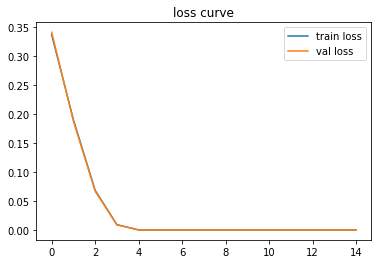

In [134]:
plt.title("loss curve")
plt.plot(np.arange(epochs), history_train_loss)
plt.plot(np.arange(epochs), history_val_loss)
plt.legend(['train loss','val loss'])
plt.show()

# 5. Testing

In [135]:
test = myDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size)

criterion_MAE = nn.L1Loss()
criterion_MSE = nn.MSELoss()

test_loss_MAE = 0
test_loss_MSE = 0

pred = []
y_true = []

for data, target in tqdm(test_loader):
    with torch.no_grad():
        data = data.squeeze(0)
        data = torch.stack((data, data, data), 1)
        data, target = Variable(data),Variable(target)
        data, target = data.to(device).to(torch.float32), target.to(device).to(torch.float32)
        output = model(data)
        pred.append(output.view(-1))
        y_true.append(target.cpu().numpy())
    test_loss_MAE += criterion_MAE(output.view(-1), target.view(-1)).data.item()
    test_loss_MSE += criterion_MSE(output.view(-1), target.view(-1)).data.item()
test_loss_MAE /= len(test_loader)
test_loss_MSE /= len(test_loader)

print('MAE: {}, MSE: {}, RMSE: {}'.format(test_loss_MAE, test_loss_MSE, math.sqrt(test_loss_MSE)))

100%|██████████| 15/15 [00:00<00:00, 25.67it/s]

MAE: 0.00012845198313395182, MSE: 3.203978072482035e-08, RMSE: 0.00017899659417100749


# 6. Result Analysis

true:[0.7], pred:[[0.69997424]]


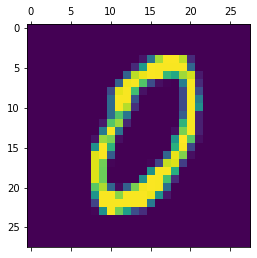

In [153]:
for data, target in test_loader:
    with torch.no_grad():
        data = data.squeeze(0)
        data = torch.stack((data, data, data), 1)
        data, target = Variable(data),Variable(target)
        data, target = data.to(device).to(torch.float32), target.to(device).to(torch.float32)
        output = model(data)
        print("true:{}, pred:{}".format(target.cpu().numpy(), output.cpu().numpy()))
        
        plt.matshow(data[0][0].cpu())
        plt.show()
        break

In [61]:
X_test.shape

(15, 100, 28, 28)

In [83]:
def result_analysis(test_loader, is_tumor):
    
#     data_0 = data[data["class"]=='0']
#     data_7 = data[data["class"]=='7']

    X_li_0 = []
    y_li_0 = []
    
    X_li_7 = []
    y_li_7 = []

    for i in tqdm(range(math.floor(data_0.shape[0]/100))):
        tmp1 = data_0.sample(n=100)
        tmp2 = data_7.sample(n=100)

        X_li_0.append(tmp1.iloc[:,:-1].to_numpy().reshape(100,28,28))
        y_li_0.append(1)
        
        X_li_7.append(tmp2.iloc[:,:-1].to_numpy().reshape(100,28,28))
        y_li_7.append(0)

    X_bag_0 = np.stack(X_li_0, axis=0)
    y_bag_0 = np.array(y_li_0)
    
    X_bag_7 = np.stack(X_li_7, axis=0)
    y_bag_7 = np.array(y_li_7)

    print(X_bag_0.shape, y_bag_0.shape)
    print(X_bag_7.shape, y_bag_7.shape)
    
    for i in range(69):
        data = torch.tensor(X_bag_7[i]).squeeze(0)
        data = torch.stack((data, data, data), 1)
        data = Variable(data)
        data = data.to(device).to(torch.float32)
        output = model(data)
        print("pred:{}, true:{}".format(output, target))
    

In [84]:
result_analysis(test_loader, False)

100%|██████████| 69/69 [00:00<00:00, 211.89it/s]


(69, 100, 28, 28) (69,)
(69, 100, 28, 28) (69,)
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0')
pred:tensor([[0.7000]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.7000], device='cuda:0'

  5%|▍         | 1/22 [00:00<00:00, 131.48it/s]


target is:  tensor(0.5600, dtype=torch.float64)
pred:tensor([[0.5142]], device='cuda:0', grad_fn=<AddmmBackward>), true:tensor([0.5600], device='cuda:0')


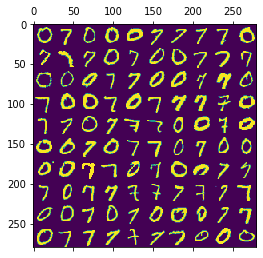

In [243]:
result_analysis(test_loader, True)

In [244]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

X_0 = X[y == '0']
X_7 = X[y == '7']

X_0.shape, X_7.shape

((6903, 784), (7293, 784))

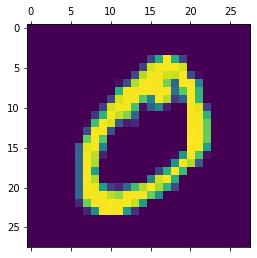

In [245]:
plt.matshow(X_0.iloc[0].to_numpy().reshape(28,28))

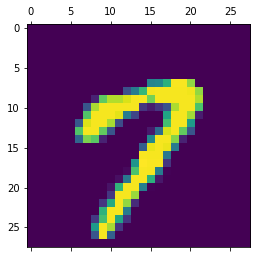

In [246]:
plt.matshow(X_7.iloc[0].to_numpy().reshape(28,28))

In [261]:
row = []
for i in range(10):
    col = []
    for j in range(10):
        col.append(X_7.iloc[0].to_numpy().reshape(28,28))
    row.append(np.hstack(col))

img = np.vstack(row)
img.shape

(280, 280)

In [262]:
img = img/255

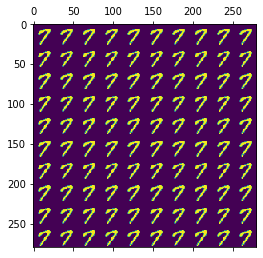

In [263]:
plt.matshow(img)

In [264]:
img = torch.from_numpy(img)
img = img.unsqueeze(0)
img = torch.stack((img, img, img), 1)
img = Variable(img)
img = img.to(device).to(torch.float32)
output = model(img)

In [265]:
output

tensor([[0.5142]], device='cuda:0', grad_fn=<AddmmBackward>)